# Model evaluation

Model evaluation is important for assessing the performance and reliability of predictive models before deployment. It helps identify potential shortcomings, biases, or overfitting issues, and assess how well models can generalize well to new, unseen data.

Here we discuss evaluation at two levels: 

* Patient level: Evaluation of the models predicting admission after ED where the outcome of interest is whether a given patient is admitted or not at the end of their visit
* Aggregate level: Evaluation of models predicting bed demand where the outcome is a predicted number of beds needed at a moment in time (referred to as a prediction moment)

We kept a test set separate from the training data for this purpose. 

### IMPORTANT - ANY MODELS TRAINED USING SYNTHETIC DATA WILL HAVE ARTIFICIALLY INFLATED MODEL PERFORMANCE. IF YOU VIEW THIS NOTEBOOK USING SUCH MODELS, THEY DO NOT REFLECT THE TRUE PERFORMANCE ON REAL PATIENT DATA. 

## 1. Individual level evaluation

a. Standard metrics used in Machine Learning, such as Area Under the Receiver Operator Curve (AUROC, or often referred to as AUC) and logloss. 

b. Calibration plots which shows how well a model's predicted probabilities match actual outcomes. Predicted probabilties are grouped in bins across the range of probabilities from 0 to 1 and compared with the observed proportion of admission in each bin

c. MAPCAP (Model Accuracy Diagnostic Calibration Plot) which, like the calibration plot, compares predicted probabilities with numbers of admission, but does this in a cumulative manner whereby predicted probabilities are ordered from 0 to 1 and admissions are summed cumulatively

## 2. Aggregate level evaluation

There are various approaches. A common approach is to generate a single number such as mean squared error. For this:

a. for each prediction moment, compare the observed number of admissions and the expected value from the probability distribution for the model predictions at that moment. These can be compared, over the whole test set, using Mean Absolute Error (MAE) - which avoids positive and negative deviations cancelling each other out - and the error can also be expressed as a percentage of observed admissions to derive a mean percentage error (MPE).  

b. for each prediction moment, compare the expected value of the probability distribution with a rolling average of six weeks [work in progress]

Given that our models generate probability distributions, we can also use methods that appraise the performance of the model across the whole distribution. We would expect the observed number of beds to appear in the lowest tenth of the distribution on 10% of prediction moments, and likewise in the highest tenth on 10% of prediction moments. If so it performs well at the tails of the distribution. This is evaluated by:

c. a QQ plot which is a tool used to compare one probility distribution with another. The key difference here is that the observed values across the test set are treated as a distribution, and compared with predicted distribution

## 3. Evaluating predictions by specialty [work in progress]

We can use the evaluation methods above and break them down by specialty. This is work in progress.

## 4. Evaluating aspirational predictions for patients in ED and yet-to-arrive patients [work in progress]

The evaluations above are all for patients currently in the ED/SDEC at the time of prediction, and the evaluations are concerned with whether each patient is eventually admitted - but not whether they were admitted within the prediction window of 8 hours. Strictly, this should be done, but this requires additional treatment, because of the aspirational time to admission that is imposed in our approach. 

If we compared our aspirational predictions of admission in 8 hours to the actual numbers admitted in 8 hours, we'd find the models overestimated how many would be admitted in that window, because the ED targets were not being met during the period of the test set. 

The same applies to the yet-to-arrive predictions. Very few patients would arrive within 8 hours of the prediction moment, and be admitted before the end of 8 hours. 

Strictly, we should evaluate the aspirational predictions nonethless, as we are producing output which is sent to bed managers at the 90% and 70% cut points on the cumulative probability distribution, and they would like to be confident that these predictions are fair. 

There is a way to do this. To illustrate, let's assume for a moment that the model always predicts they'll need at least 2 medical beds with 90% probability, and 3 with 70% probability. 

On 90% of days when we make that prediction, the observed number of medical beds needed within 8 hours (after applying the aspirational curve to observed arrivals times) should be 2 or more and on 70% of days it should be 3 or more. 

We can generate such evaluation, with a bit of additional processing. This is work in progress.

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json
import pandas as pd

root = Path().resolve().parent

sys.path.append(str(root/ 'src' ))

## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [10]:
# indicate whether the notebook is being run locally for UCLH or with public datasets
uclh = False
from patientflow.load import set_file_paths
from patientflow.load import load_config_file

# set file locations
data_folder_name = 'data-uclh' if uclh else 'data-public'
data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
        train_dttm = None, data_folder_name = data_folder_name, uclh = uclh, from_notebook=True, inference_time = False)

# load params
params = load_config_file(config_path)

prediction_times = params["prediction_times"]
start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]
x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
epsilon = float(params["epsilon"])
yta_time_interval = params["yta_time_interval"]

print(f'\nTraining set starts {start_training_set} and ends on {start_validation_set - pd.Timedelta(days=1)} inclusive')
print(f'Validation set starts on {start_validation_set} and ends on {start_test_set - pd.Timedelta(days=1)} inclusive' )
print(f'Test set starts on {start_test_set} and ends on {end_test_set- pd.Timedelta(days=1)} inclusive' )

print(f'\nThe coordinates used to derive the aspirational curve are ({int(x1)},{y1}) and ({int(x2)},{y2})')
print(f'The prediction window over which prediction will be made is {prediction_window/60} hours')
print(f'In order to calculate yet-to-arrive rates of arrival, the prediction window will be divied into intervals of {yta_time_interval} minutes')


Configuration will be loaded from: /home/jovyan/work/patientflow/config.yaml
Data files will be loaded from: /home/jovyan/work/patientflow/data-public
Trained models will be saved to: /home/jovyan/work/patientflow/trained-models
Images will be saved to: /home/jovyan/work/patientflow/notebooks/img

Training set starts 2031-03-01 and ends on 2031-08-31 inclusive
Validation set starts on 2031-09-01 and ends on 2031-09-30 inclusive
Test set starts on 2031-10-01 and ends on 2031-12-31 inclusive

The coordinates used to derive the aspirational curve are (4,0.76) and (12,0.99)
The prediction window over which prediction will be made is 8.0 hours
In order to calculate yet-to-arrive rates of arrival, the prediction window will be divied into intervals of 15 minutes


## Load data

In [4]:
import pandas as pd
from patientflow.load import set_data_file_names
from patientflow.load import data_from_csv

if uclh:
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_data_file_names(uclh, data_file_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_data_file_names(uclh, data_file_path)

visits = data_from_csv(visits_csv_path, index_column = 'snapshot_id',
                            sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                            eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])

visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date



## 1. Evaluation of the models predicting admission to ED (at individual patient level)

For details of how the modelling was done see notebook [4a_Predict_Probability_of_admission_from_ED.ipynb](4a_Predict_Probability_of_admission_from_ED.ipynb)

### 1a. Standard metrics used in Machine Learning

First we will look at standard metrics commonly used in Machine Learning. We reload the results dictionary that we saved to file at the time of training. All AUCs are acceptable. The best performing models are later in the day. 

In [6]:
from patientflow.load import get_model_name
filename_results_dict_name = 'model_metadata.json'
filename_results_dict_path = model_file_path / "model-output"
full_path_results_dict = filename_results_dict_path / filename_results_dict_name

with open(full_path_results_dict, 'r') as f:
    model_metadata = json.load(f)

# see performance of best model for each time of day
model_name = 'admissions'
for _prediction_time in prediction_times:
    MODEL__ED_ADMISSIONS__NAME = get_model_name(model_name, _prediction_time)
    best_model_results_dict = model_metadata[MODEL__ED_ADMISSIONS__NAME]['test_set_results']
    print(f"Model: {MODEL__ED_ADMISSIONS__NAME}; AUC: {round(best_model_results_dict['test_auc'],3)}; log loss {round(best_model_results_dict['test_logloss'],3)}")

Model: admissions_0600; AUC: 0.778; log loss 0.494
Model: admissions_0930; AUC: 0.763; log loss 0.393
Model: admissions_1200; AUC: 0.79; log loss 0.344
Model: admissions_1530; AUC: 0.794; log loss 0.41
Model: admissions_2200; AUC: 0.84; log loss 0.411


We can compare this with the minimal model that was trained (Note that if you have not run the code in notebook 4a, this model will not be saved in your local folder):

In [8]:
from patientflow.load import get_model_name
filename_results_dict_name = 'minimal_model_metadata.json'
filename_results_dict_path = model_file_path / "model-output"
full_path_results_dict = filename_results_dict_path / filename_results_dict_name

with open(full_path_results_dict, 'r') as f:
    model_metadata = json.load(f)

# see performance of best model for each time of day
model_name = 'admissions_minimal'
for _prediction_time in prediction_times:
    MODEL__ED_ADMISSIONS__NAME = get_model_name(model_name, _prediction_time)
    best_model_results_dict = model_metadata[MODEL__ED_ADMISSIONS__NAME]['test_set_results']
    print(f"Model: {MODEL__ED_ADMISSIONS__NAME}; AUC: {round(best_model_results_dict['test_auc'],3)}; log loss {round(best_model_results_dict['test_logloss'],3)}")

Model: admissions_minimal_0600; AUC: 0.665; log loss 0.531
Model: admissions_minimal_0930; AUC: 0.664; log loss 0.414
Model: admissions_minimal_1200; AUC: 0.668; log loss 0.386
Model: admissions_minimal_1530; AUC: 0.683; log loss 0.454
Model: admissions_minimal_2200; AUC: 0.751; log loss 0.471


### 1b. Calibration plots

A calibration plot shows how well a model's predicted probabilities match actual outcomes.

- X-axis (Mean Predicted Probability): The model's predicted probabilities, ordered from 0 to 1, grouped into bins, either using the uniform or the quantile strategy (see below).
- Y-axis (Fraction of Positives): The observed proportion of admissions for visits in that group.

A perfectly calibrated model would align its points along the diagonal line, meaning a 70% predicted probability means the event happens 70% of the time.

Uniform vs Quantile Strategies:
- Uniform: Divides predictions into equal-width probability bins (e.g., 0.0-0.1, 0.1-0.2), so some bins may have few or many points.
- Quantile: Ensures each bin has the same number of predictions, regardless of how wide or narrow each bin's probability range is.


In [15]:
model_file_path


PosixPath('/home/jovyan/work/patientflow/trained-models')

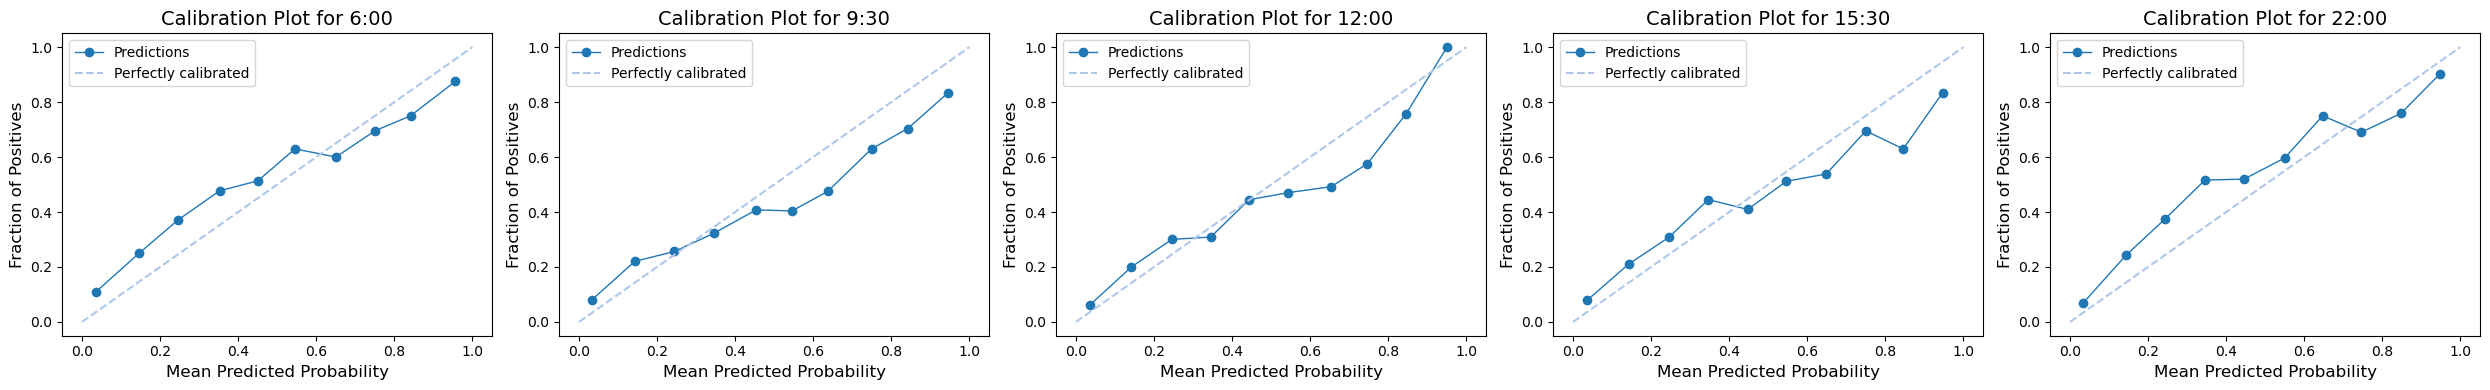

In [18]:
from patientflow.viz.calibration_plot import plot_calibration
plot_calibration(prediction_times, media_file_path, model_file_path, visits_csv_path, model_name = 'admissions', strategy = 'uniform')


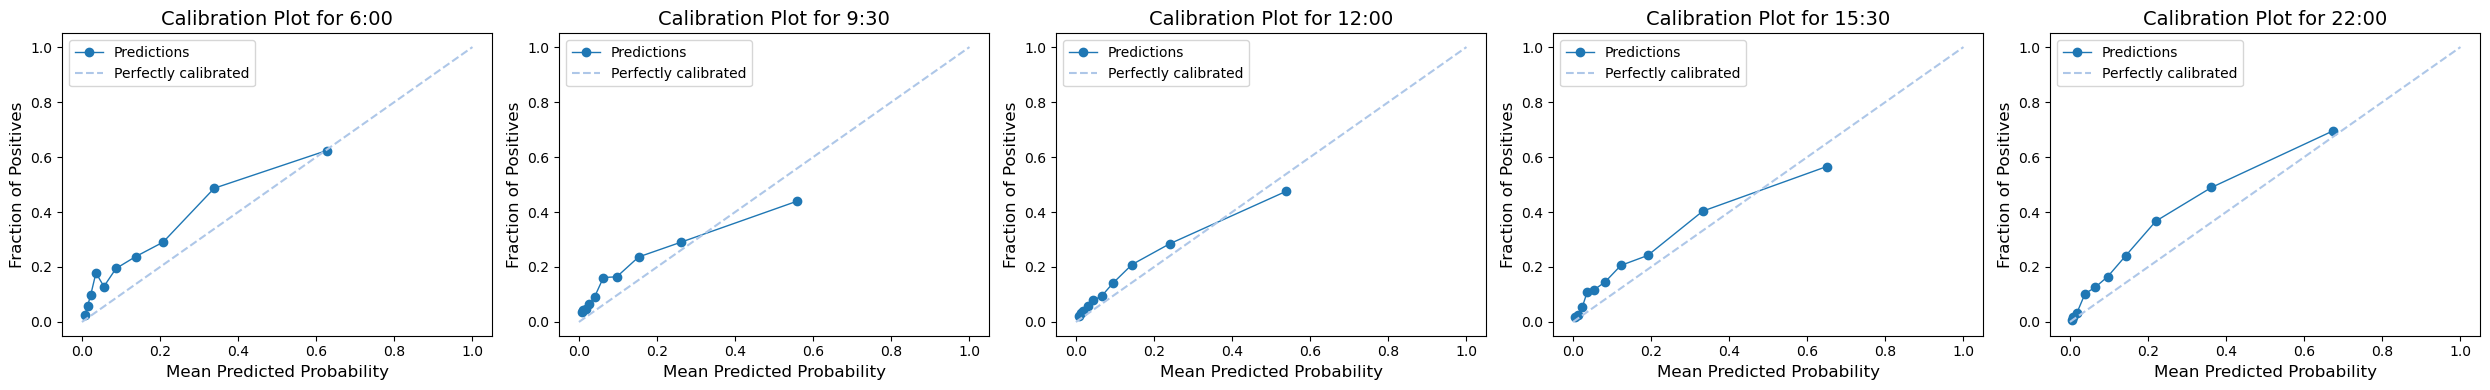

In [19]:
plot_calibration(prediction_times, media_file_path, model_file_path, visits_csv_path, model_name = 'admissions',  strategy = 'quantile')



### 1c .MADCAP plots

A MADCAP (Model Accuracy Diagnostic Calibration Plot) visually compares the predicted probabilities from a model with the actual outcomes (e.g., admissions or events) in a dataset. This plot helps to assess how well the model's predicted probabilities align with the observed values.

The blue line represents the cumulative predicted outcomes, which are derived by summing the predicted probabilities as we move through the test set, ordered by increasing probability.
The orange line represents the cumulative observed outcomes, calculated based on the actual labels in the dataset, averaged over the same sorted order of predicted probabilities.

If the model is well calibrated, these two lines will closely follow each other, and the curves will bow to the bottom left. 

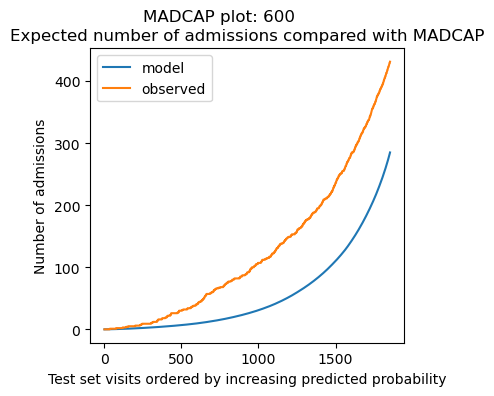

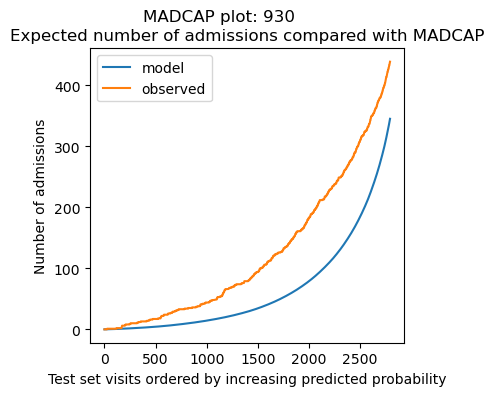

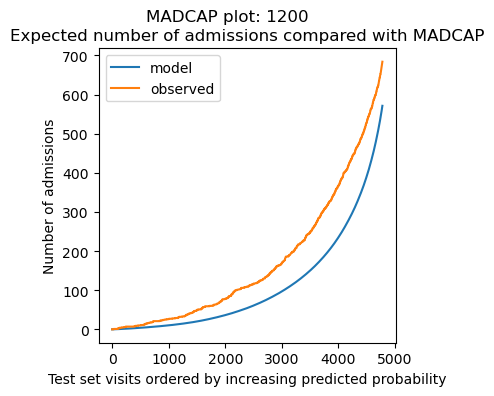

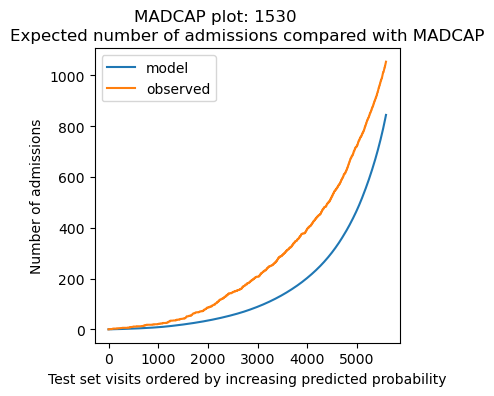

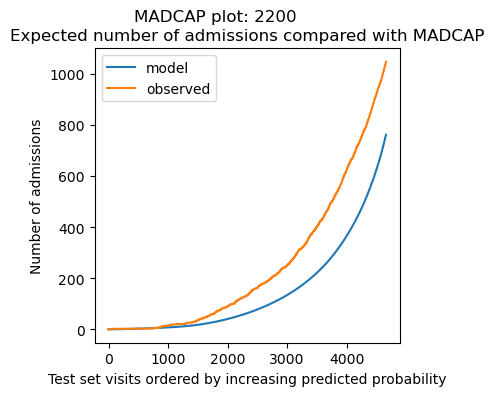

In [20]:
from patientflow.viz.madcap_plot import plot_madcap, plot_madcap_by_group
from patientflow.prepare import prepare_for_inference

exclude_from_training_data = [
    "visit_number",
    "snapshot_date",
    "prediction_time",
    "specialty",
    "consultation_sequence",
     "final_sequence"]


from patientflow.prepare import get_snapshots_at_prediction_time
# Create a function to classify age groups
def classify_age_group(age_group):
    if age_group in ['0-17']:
        return 'children'
    elif age_group in ['18-24', '25-34', '35-44', '45-54', '55-64']:
        return 'adults'
    elif age_group in ['65-74', '75-102']:
        return 'over 65'
    else:
        return 'unknown' # Handle potential NaN or unexpected values

def classify_age(age_on_arrival):
    if age_on_arrival < 18:
        return 'children'
    elif age_on_arrival < 65:
        return 'adults'
    elif age_on_arrival >= 65:
        return '65 or over'
    else:
        return 'unknown' # Handle potential NaN or unexpected values
        
def generate_madcap_plots(prediction_times, grouping_var = None, grouping_var_name = None):
    
    for i, _prediction_time in enumerate(prediction_times):
        hour, minutes = _prediction_time
        dataset = f'{hour}{minutes:02}'
        
        X_test, y_test, pipeline = prepare_for_inference(
            model_file_path, 
            'admissions', 
            prediction_time = _prediction_time, 
            data_path = visits_csv_path, 
            single_snapshot_per_visit = False)


        predict_proba = pipeline.predict_proba(X_test)[:,1]

        if grouping_var:

            if 'age_group' in X_test.columns:

                group = X_test['age_group'].apply(classify_age_group)
            else:
                group = X_test['age_on_arrival'].apply(classify_age)
                
            plot_madcap_by_group(predict_proba, y_test , group, 
                                    dataset, grouping_var_name, media_file_path, plot_difference = False)
        
        else:
            plot_madcap(predict_proba, y_test, dataset, media_file_path, plot_difference = False)


generate_madcap_plots(prediction_times)


The plots below are separated into age groups. The models do best for adults, for which there are many more observations than for children, and do better for patients over 65 in the 1200 and 1530 models. 

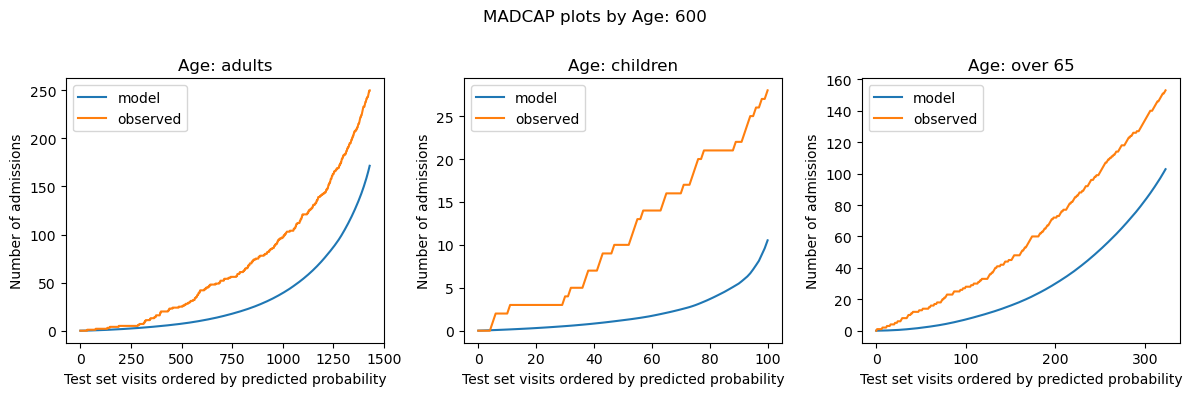

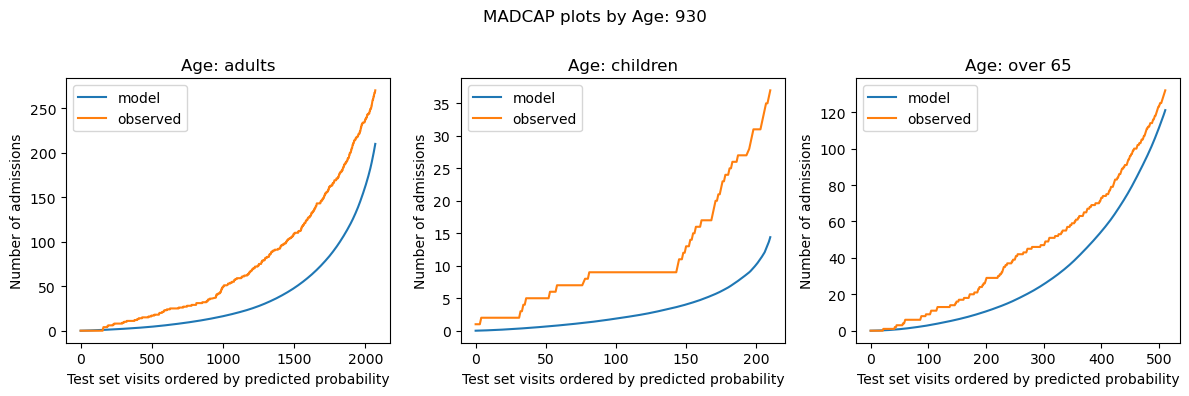

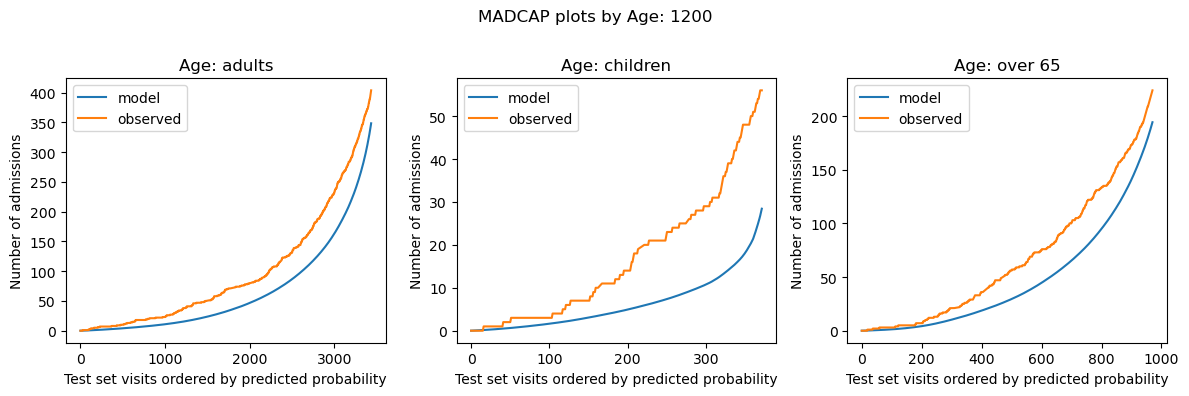

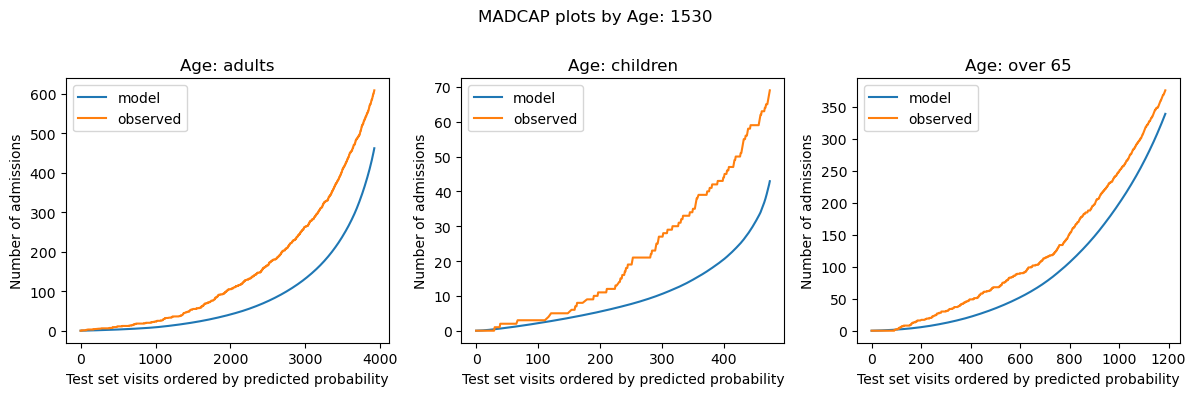

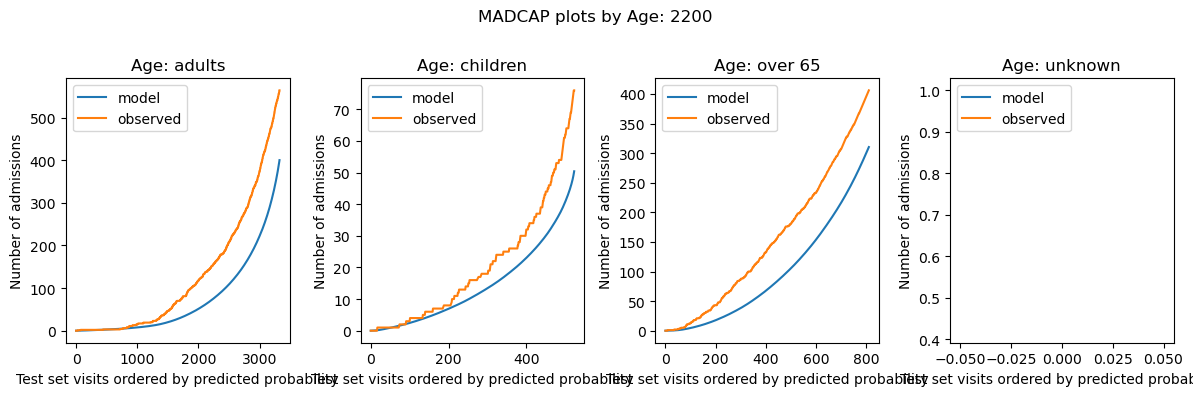

In [21]:

generate_madcap_plots(prediction_times, 'age_group', 'Age')

## 2. Evaluation of the models predicting admission to ED (at aggregate level for each snapshot)

As the ultimate objective for these models is to predict bed numbers, not patient-level probability of admission, we need a way to evaluate the aggregate level. 

In order to evaluate the models' performance in aggregate, we first need to iterate through each snapshot date in the test set, creating a dictionary of all the predictions. The dictionary saves a probability distribution for each snapshot date, and the observed number of patients in the ED at that moment, who were actually admitted.




In [23]:
from patientflow.prepare import prepare_for_inference, prepare_snapshots_dict
from patientflow.load import get_model_name
from patientflow.aggregate import get_prob_dist

prob_dist_dict_all = {}
# Process each time of day
for _prediction_time in prediction_times:

    print("\nProcessing :" + str(_prediction_time))
    
    model_name = get_model_name('ed_admission', _prediction_time)

    # prepare data 
    X_test, y_test, model = prepare_for_inference(model_file_path, 
        'admissions', 
        prediction_time = _prediction_time, 
        data_path = Path(data_file_path, visits_csv_path), 
        single_snapshot_per_visit = False)


    # select the snapshots to include in the probability distribution, 
    snapshots_dict = prepare_snapshots_dict(
        visits[(visits.training_validation_test == 'test') &
         (visits.prediction_time == _prediction_time)]
        )
    
    # get probability distribution for this time of day
    prob_dist_dict_all[model_name] = get_prob_dist(
            snapshots_dict, X_test, y_test, model
        )


Processing :(6, 0)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates

Processing :(9, 30)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates

Processing :(12, 0)
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot

In [17]:
prob_dist_dict_all.keys()

dict_keys(['ed_admission_0600', 'ed_admission_0930', 'ed_admission_1200', 'ed_admission_1530', 'ed_admission_2200'])

Here we calculate mean average error and mean performance error across the test set

In [24]:
import numpy as np

def calc_mae_mpe(prob_dist_dict_all):

    results = {}

    for _prediction_time in prob_dist_dict_all.keys():
        expected_values = []
        observed_values = []
        
        for dt in prob_dist_dict_all[_prediction_time].keys():
            data = prob_dist_dict_all[_prediction_time][dt]
            
            # expected_value = np.dot(data['agg_predicted'].index, data['agg_predicted'].values.flatten())
            expected_value = data['agg_predicted'].idxmax().values[0] 
            observed_value = data['agg_observed']
            
            expected_values.append(expected_value)
            observed_values.append(observed_value)
        
        # Convert to numpy arrays for easier calculations
        expected_array = np.array(expected_values)
        observed_array = np.array(observed_values)
        
        # Calculate absolute errors
        absolute_errors = np.abs(expected_array - observed_array)
        
        # Calculate MAE
        mae = np.mean(absolute_errors)
        
        # Remove items where observed value is zero
        non_zero_mask = observed_array != 0
        filtered_absolute_errors = absolute_errors[non_zero_mask]
        filtered_observed_array = observed_array[non_zero_mask]
        
        # Calculate percentage errors (only for non-zero observed values)
        percentage_errors = filtered_absolute_errors / filtered_observed_array * 100
        
        # Calculate MPE
        mpe = np.mean(percentage_errors)
        
        results[_prediction_time] = {
            'expected': expected_values,
            'observed': observed_values,
            'mae': mae,
            'mpe': mpe
        }

    return(results)

results = calc_mae_mpe(prob_dist_dict_all)
# Print results for verification
for _prediction_time, values in results.items():
    print(f"\n{_prediction_time}:")
    print(f"  MAE: {values['mae']:.2f}")
    print(f"  MPE: {values['mpe']:.2f}%")


ed_admission_0600:
  MAE: 2.03
  MPE: 44.26%

ed_admission_0930:
  MAE: 1.70
  MPE: 35.83%

ed_admission_1200:
  MAE: 2.23
  MPE: 29.81%

ed_admission_1530:
  MAE: 2.97
  MPE: 24.18%

ed_admission_2200:
  MAE: 3.68
  MPE: 31.12%


Here we plot the observed with the expected values for each prediction moment

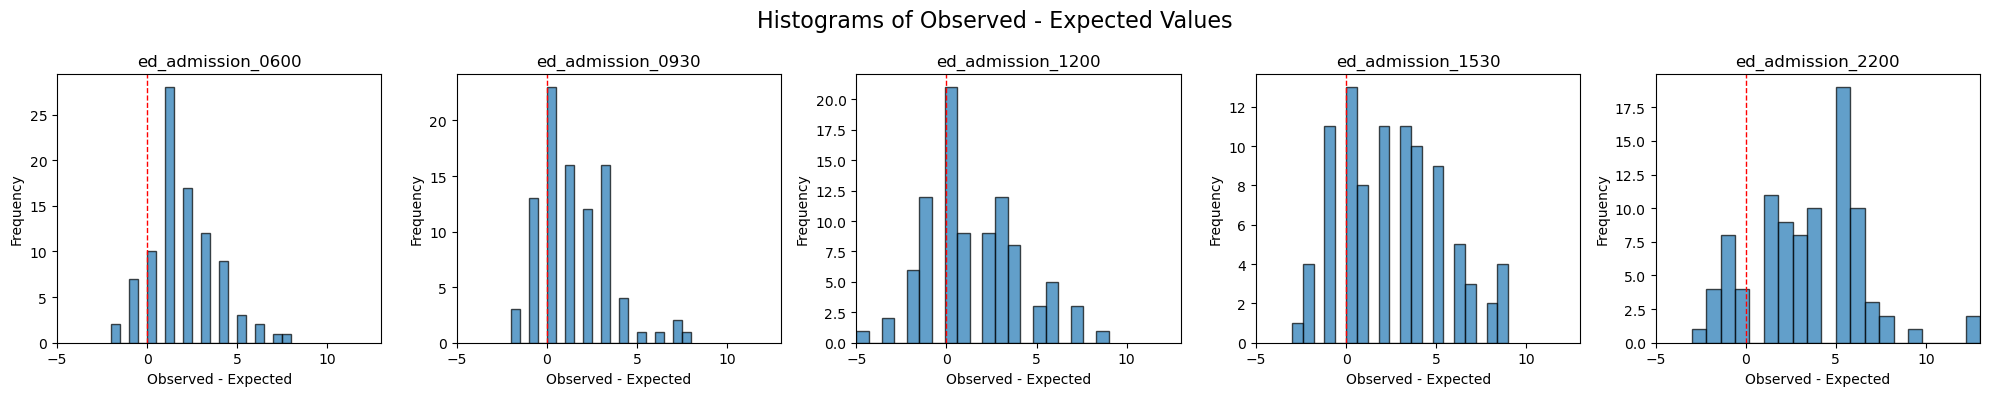

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# First, calculate the overall min and max for the differences
all_differences = []
for values in results.values():
    observed = np.array(values['observed'])
    expected = np.array(values['expected'])
    difference = observed - expected
    all_differences.extend(difference)

overall_min = min(all_differences)
overall_max = max(all_differences)

# Create the plot
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Histograms of Observed - Expected Values', fontsize=16)

for i, (_prediction_time, values) in enumerate(results.items()):
    observed = np.array(values['observed'])
    expected = np.array(values['expected'])
    difference = observed - expected
    
    axes[i].hist(difference, bins=20, edgecolor='black', alpha=0.7)  # Added alpha for translucency
    axes[i].axvline(x=0, color='r', linestyle='--', linewidth=1)  # Added vertical line at x=0
    axes[i].set_title(_prediction_time)
    axes[i].set_xlabel('Observed - Expected')
    axes[i].set_ylabel('Frequency')
    
    # Set consistent x-axis limits
    axes[i].set_xlim(overall_min, overall_max)

plt.tight_layout()
plt.show()

### 2c. QQ Plots

A  qq plot compares a predicted distribution to an observed distribution. In this case, the predicted distribution is the combined set of probability distributions (one for each snapshot date in the test set) at the given prediction time. The observed distribution is derived from the actual number of patients who were later admitted in each of those snapshot dates. 

If the predicted and observed distributions are similar, the qq plot should adhere closely to the y = x line in the plot. 


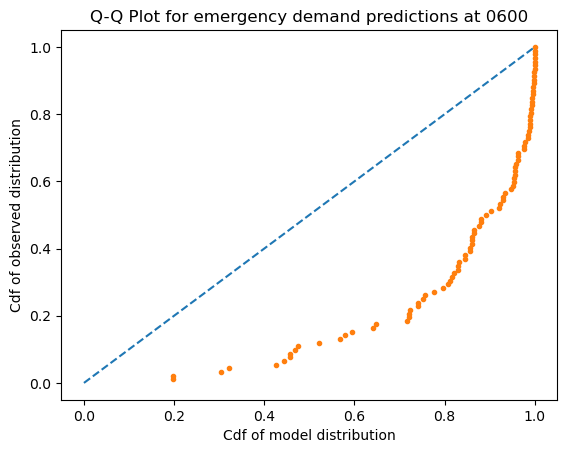

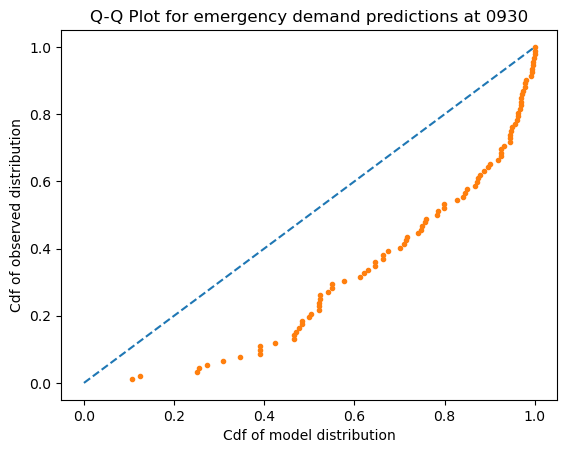

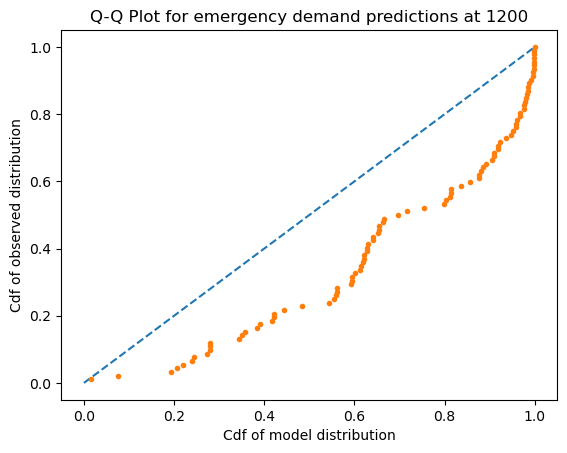

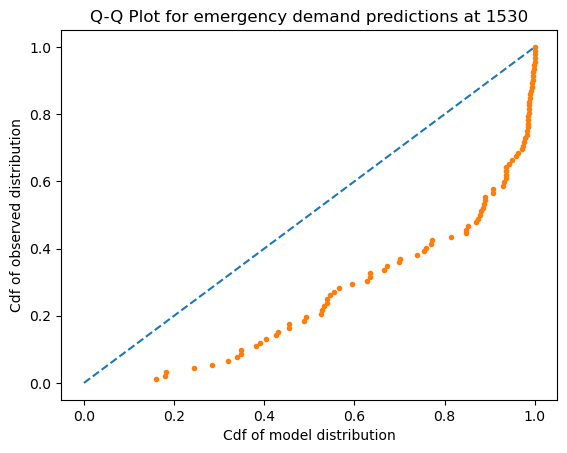

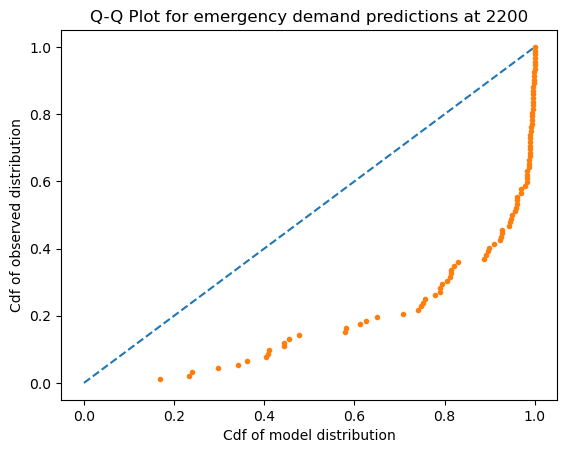

In [26]:
from patientflow.viz.qq_plot import qq_plot

for _prediction_time in prediction_times:
    
    # retrieve name for the model based on the time of day
    hour_, min_ = _prediction_time
    min_ = f"{min_}0" if min_ % 60 == 0 else str(min_)
    model_name = 'ed_admission_' + f"{hour_:02}" + min_
    
    title_ = 'Q-Q Plot for emergency demand predictions at ' + f"{hour_:02}" + min_

    plt = qq_plot(snapshots_dict.keys(), prob_dist_dict_all[model_name], title_)
    
    # use model name in the path for saving the plot
    qq_plot_path = media_file_path / model_name 
    qq_plot_path = qq_plot_path.with_suffix('.png')
    
    plt.savefig(qq_plot_path)
        